In [1]:
import numpy as np
import random

from repath.utils.paths import project_root
import repath.data.datasets.camelyon16 as camelyon16
import repath.data.datasets.cervical_debug as cervical
from repath.data.datasets.dataset import Dataset
from repath.preprocess.tissue_detection import TissueDetectorGreyScale
from repath.preprocess.patching import GridPatchFinder, SlidesIndex, CombinedIndex
from repath.preprocess.sampling import split_cervical_tags, balanced_sample
from repath.utils.seeds import set_seed

In [2]:
experiment_name = "cervical_debug"
experiment_root = project_root() / "experiments" / experiment_name
tissue_detector = TissueDetectorGreyScale()

global_seed = 123

In [3]:
def preprocess_indexes() -> None:
    """ Generates patch_index files for train and validation slide
    """
    set_seed(global_seed)
    # index all the patches for the camelyon16 dataset
    train_data = cervical.debug()
    patch_finder = GridPatchFinder(labels_level=5, patch_level=0, patch_size=256, stride=256)
    train_patches = SlidesIndex.index_dataset(train_data, tissue_detector, patch_finder)
    
    train, valid = split_cervical_tags(train_patches)
    
    print(train)

    train.save(experiment_root / "train_index")
    valid.save(experiment_root / "valid_index")


In [4]:
#preprocess_indexes()

In [5]:
def preprocess_samples() -> None:
    set_seed(global_seed)
    # initalise datasets
    train_data = cervical.debug()

    # load in the train and valid indexes
    train = SlidesIndex.load(train_data, experiment_root / "train_index")

    # sample from train and valid sets
    train_samples = balanced_sample([train], 40000)

    # save out all the patches
    train_samples.save_patches(experiment_root / "training_patches")


In [6]:
#preprocess_samples()

In [7]:
train_data = cervical.debug()
slide_idx = 20
notblank = True

dataset = train_data
patch_finder = GridPatchFinder(labels_level=5, patch_level=0, patch_size=256, stride=256)

slide_path, annotation_path, _, _ = dataset[slide_idx]
with dataset.slide_cls(slide_path) as slide:
    print(f"indexing {slide_path.name}")  # TODO: Add proper logging!
    if patch_finder.labels_level >= len(slide.dimensions):
        request_level = len(slide.dimensions) - 1
        lev_diff = patch_finder.labels_level - request_level
        max_level_dim = slide.dimensions[-1]
        requested_level_size = Size(max_level_dim.width // 2 ** lev_diff, max_level_dim.height // 2 ** lev_diff)
        labels_shape = requested_level_size.as_shape()
    else:
        labels_shape = slide.dimensions[patch_finder.labels_level].as_shape()
    if notblank:
        annotations = dataset.load_annotations(annotation_path)
        scale_factor = 2 ** patch_finder.labels_level
        labels_image = annotations.render(labels_shape, scale_factor)
    else:
        labels_image = np.ones(labels_shape)
        
    thumb = slide.get_thumbnail(patch_finder.labels_level)
    tissue_mask = tissue_detector(slide.get_thumbnail(patch_finder.labels_level))
    labels_image[~tissue_mask] = 0

indexing IC-CX-00037-01.isyntax


In [8]:
print(len(annotations.annotations))
np.unique(labels_image)

8


array([0, 1, 4])

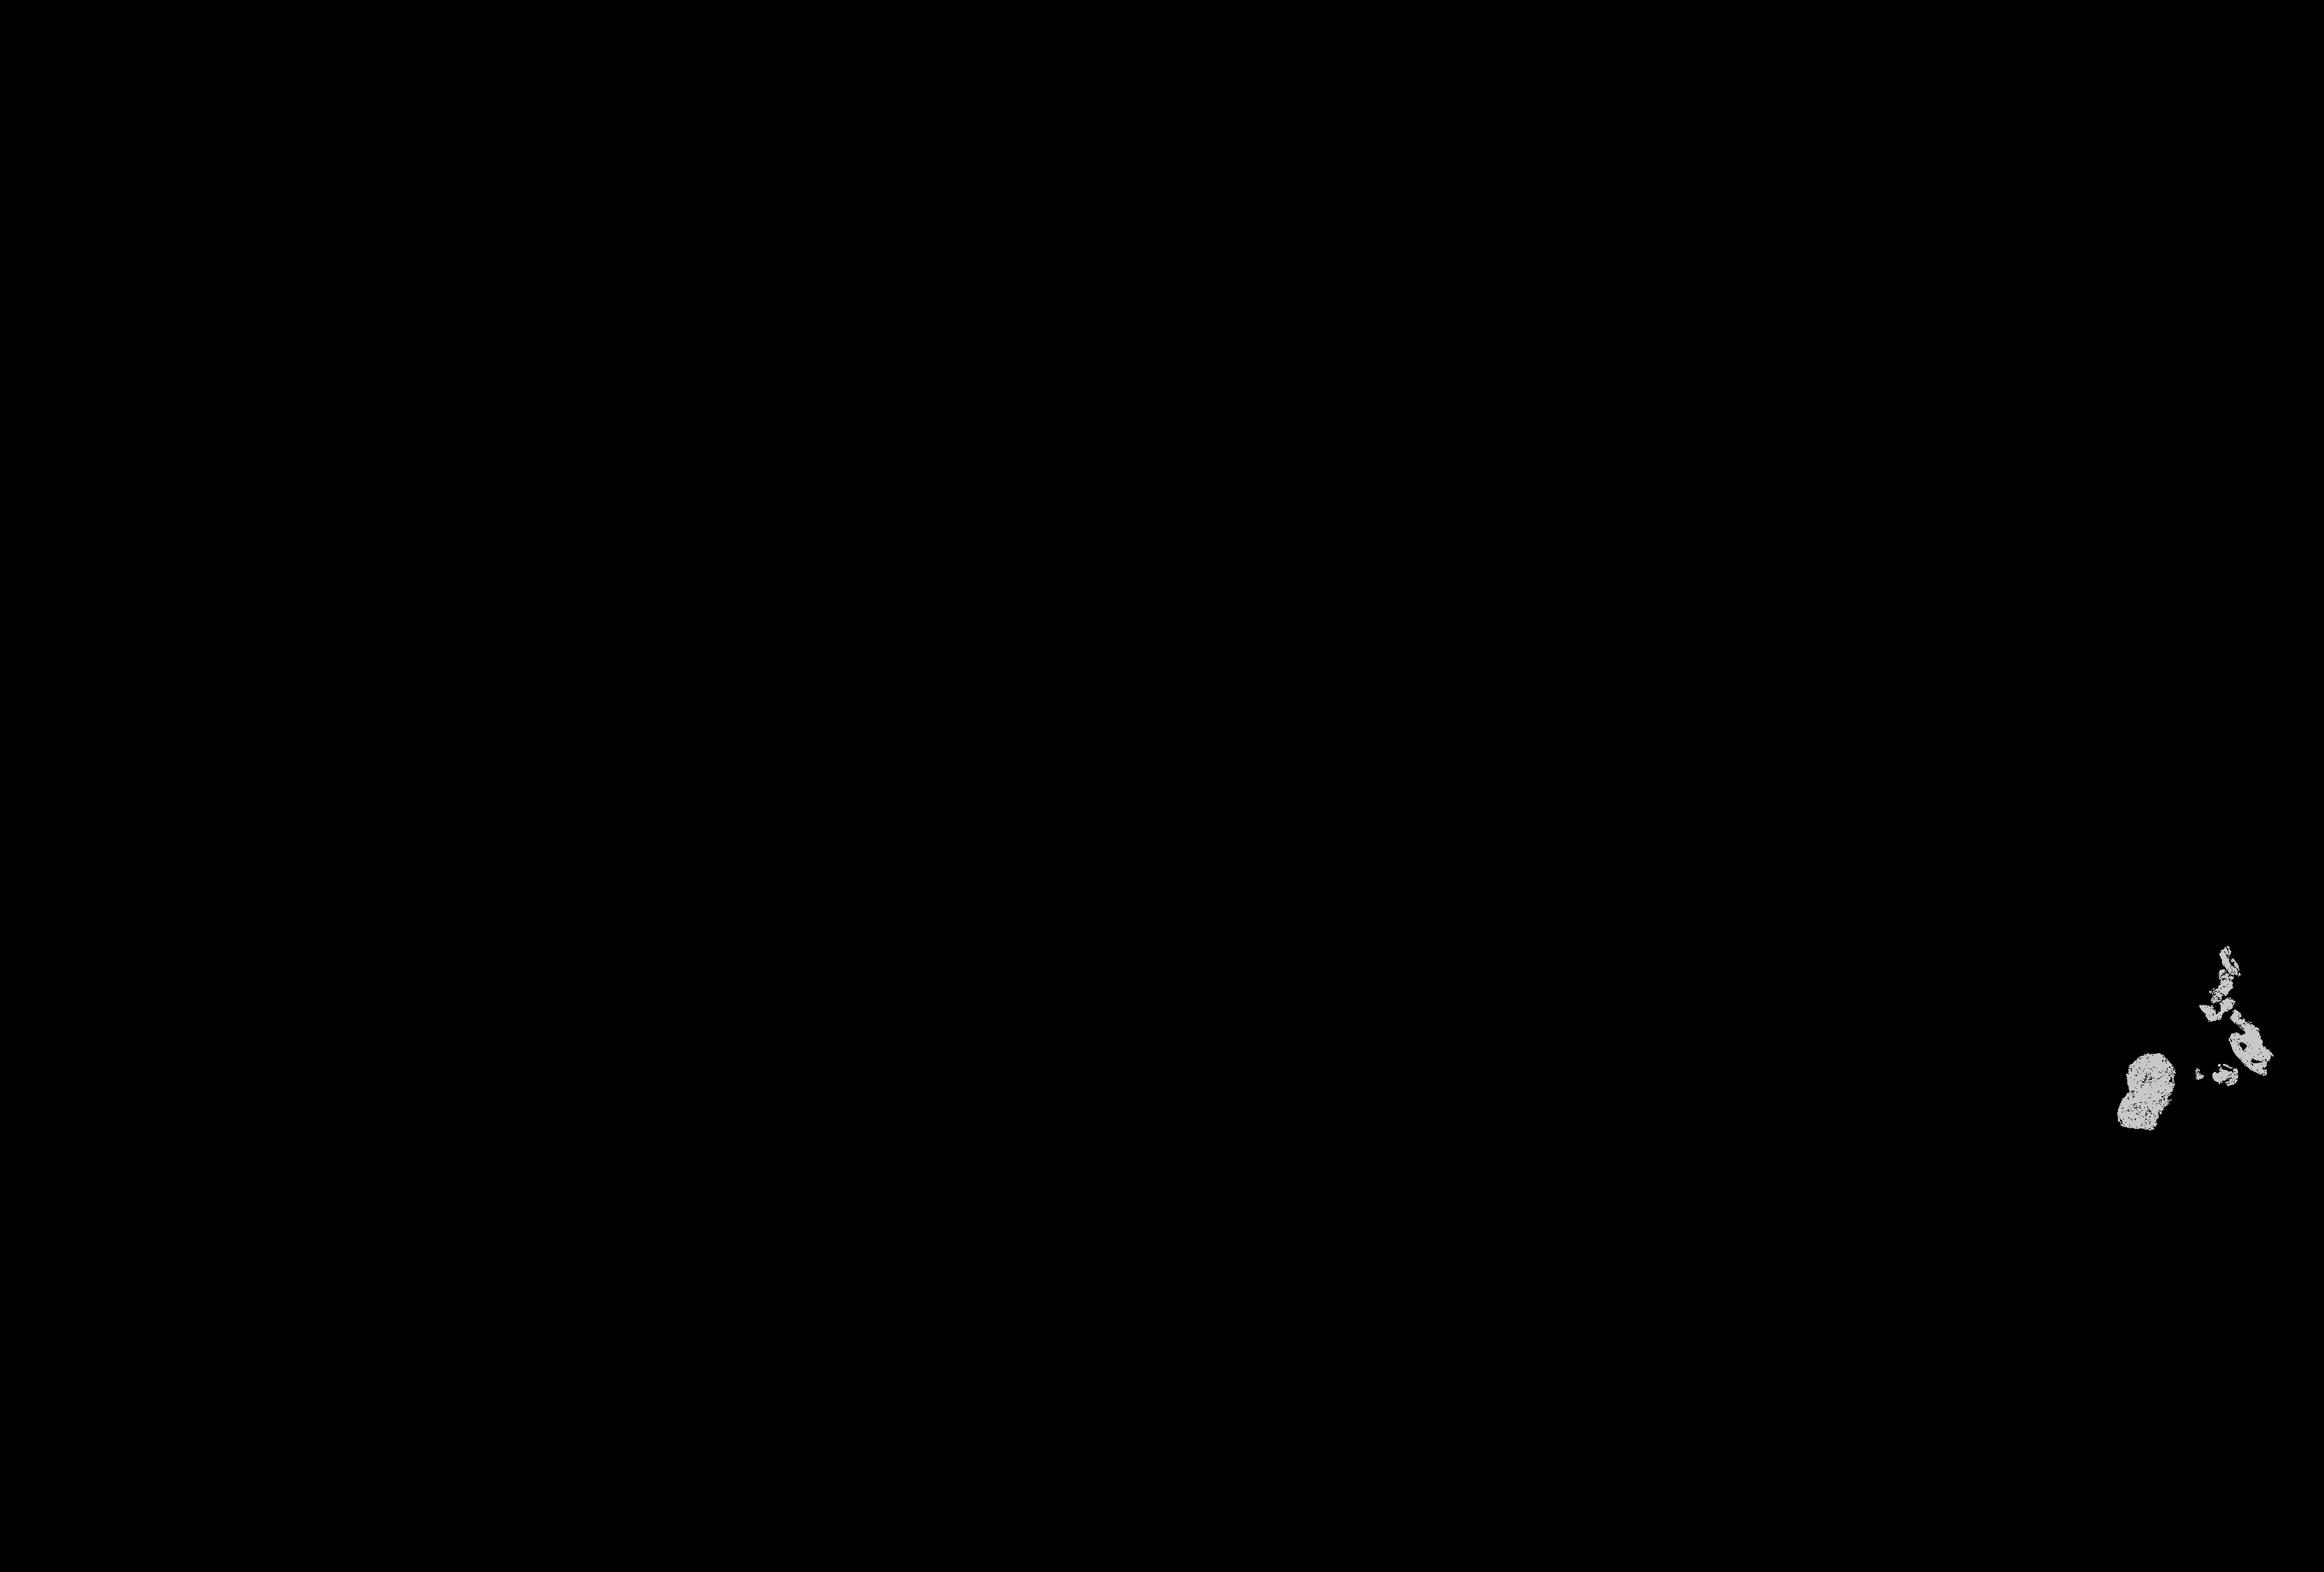

In [9]:
from PIL import Image

Image.fromarray(np.array(labels_image == 4, dtype=np.uint8)*200)

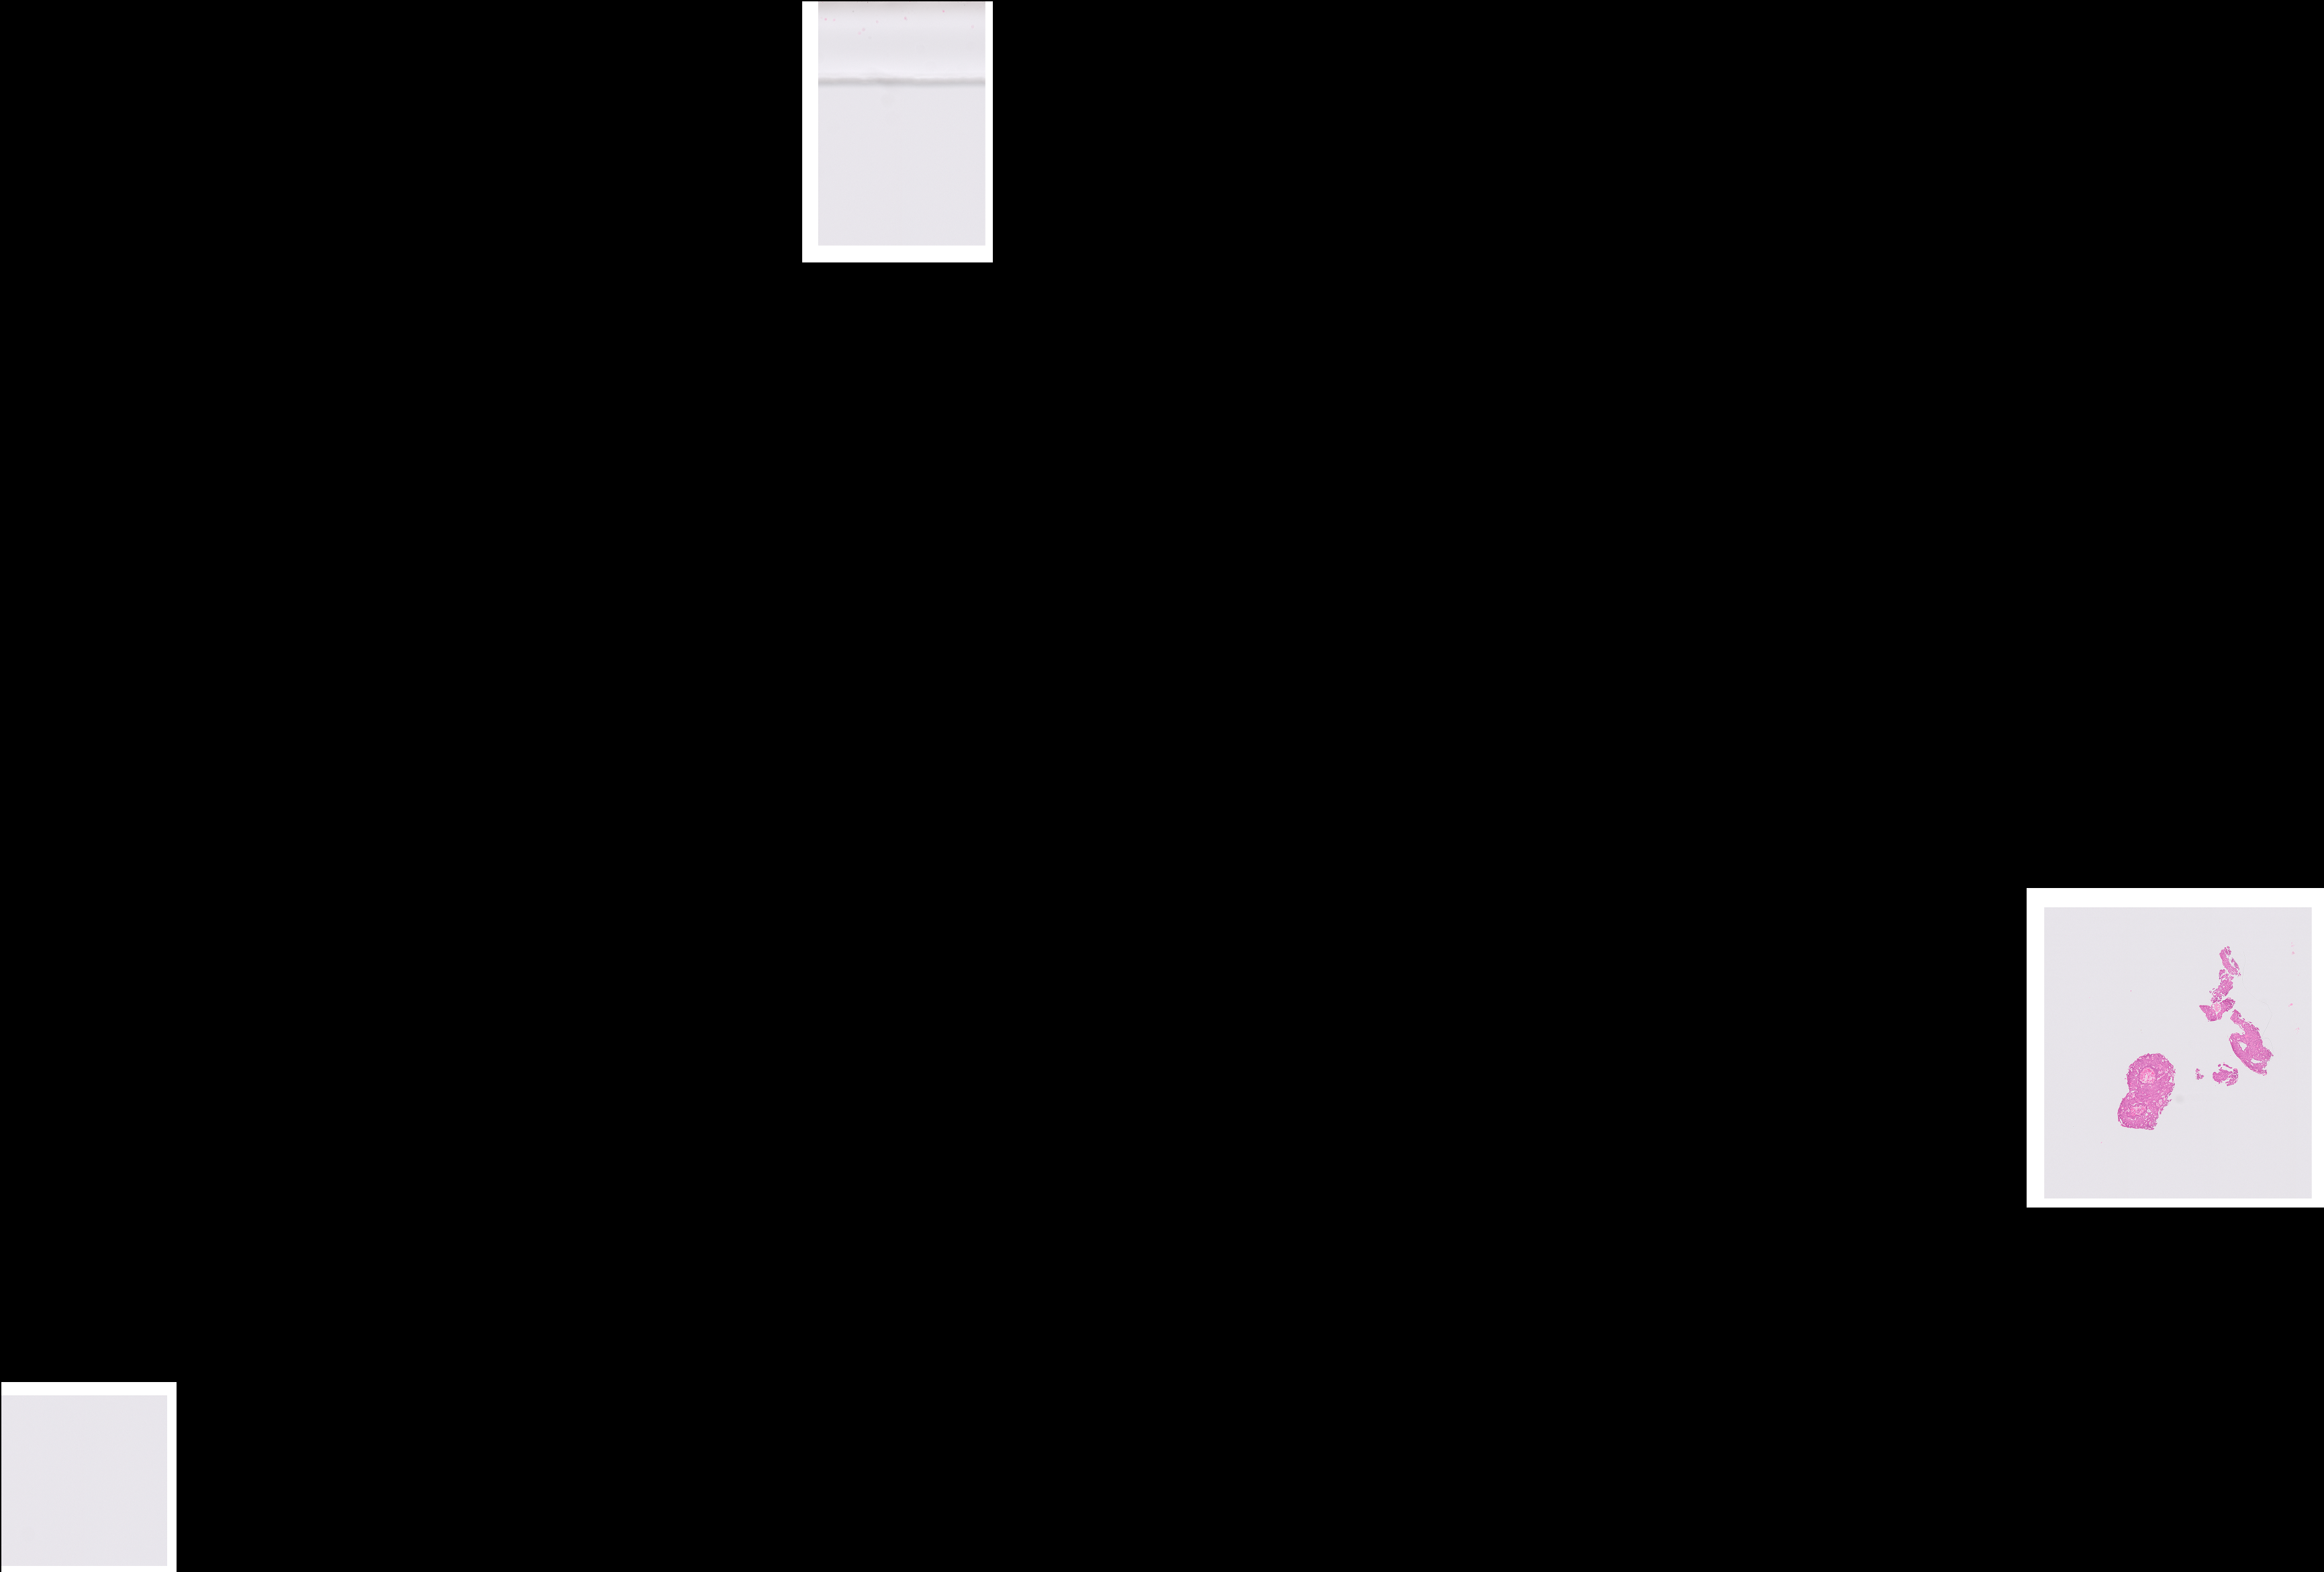

In [10]:
Image.fromarray(thumb)

In [11]:
import os

heatmap_dir = experiment_root / "pre_hnm_results" / "valid" / "heatmaps"
heatmaps = os.listdir(heatmap_dir)


In [12]:
from PIL import Image
ii = -1
import pandas as pd

heatmaps.sort()

IC-CX-00015-01_high_grade.png


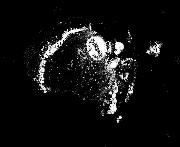

In [13]:
ii += 1
print(heatmaps[ii])
Image.open(heatmap_dir / heatmaps[ii])

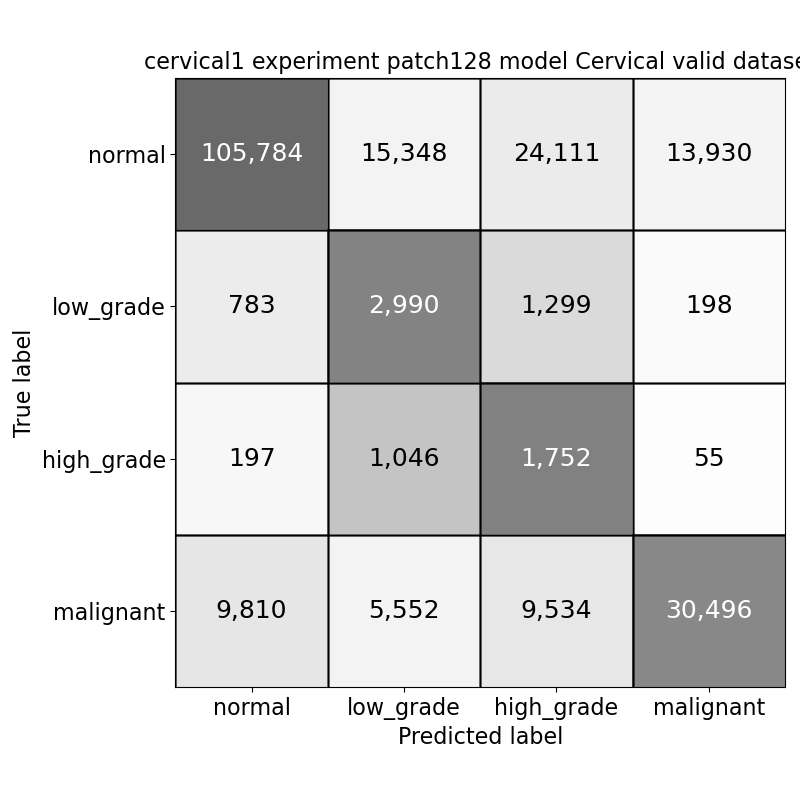

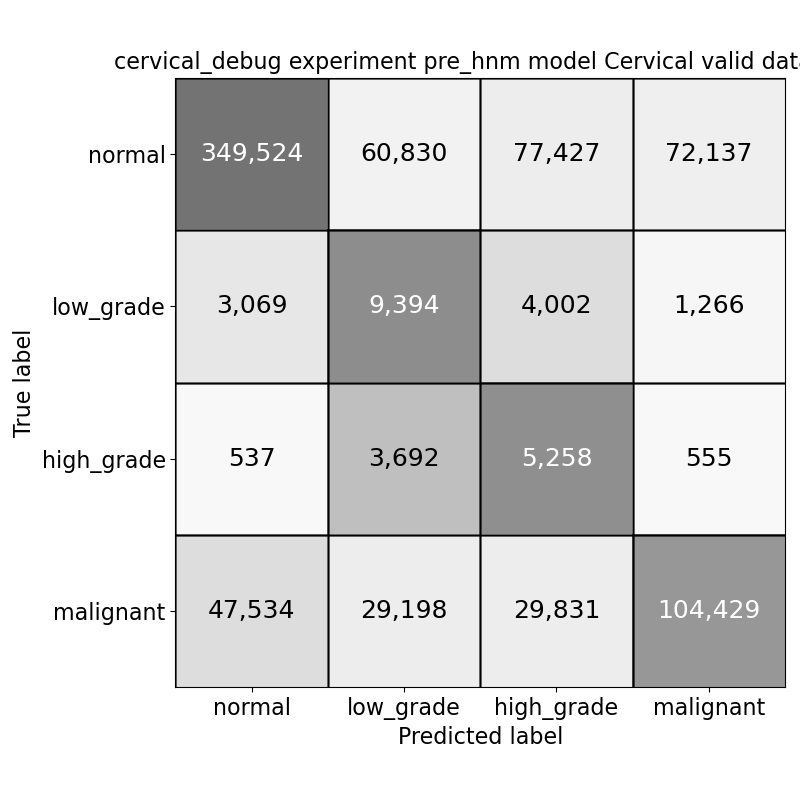

In [14]:
Image.open(experiment_root / 'pre_hnm_results' / 'patch_summaries' / 'valid' / 'confidence_matrix.png')

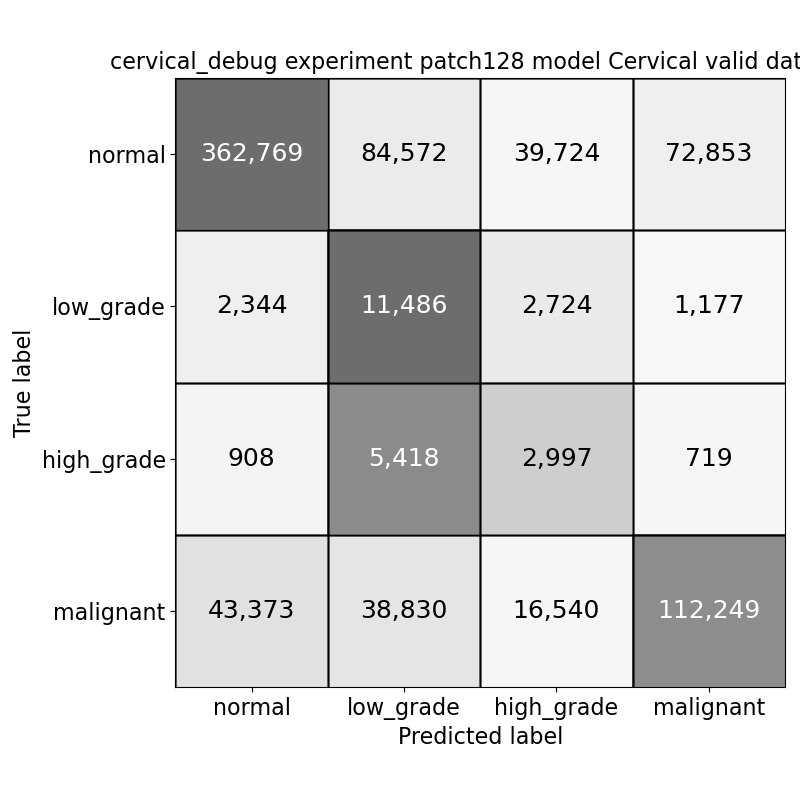

In [15]:
Image.open(experiment_root / 'patch128_results' / 'patch_summaries' / 'valid' / 'confidence_matrix.png')

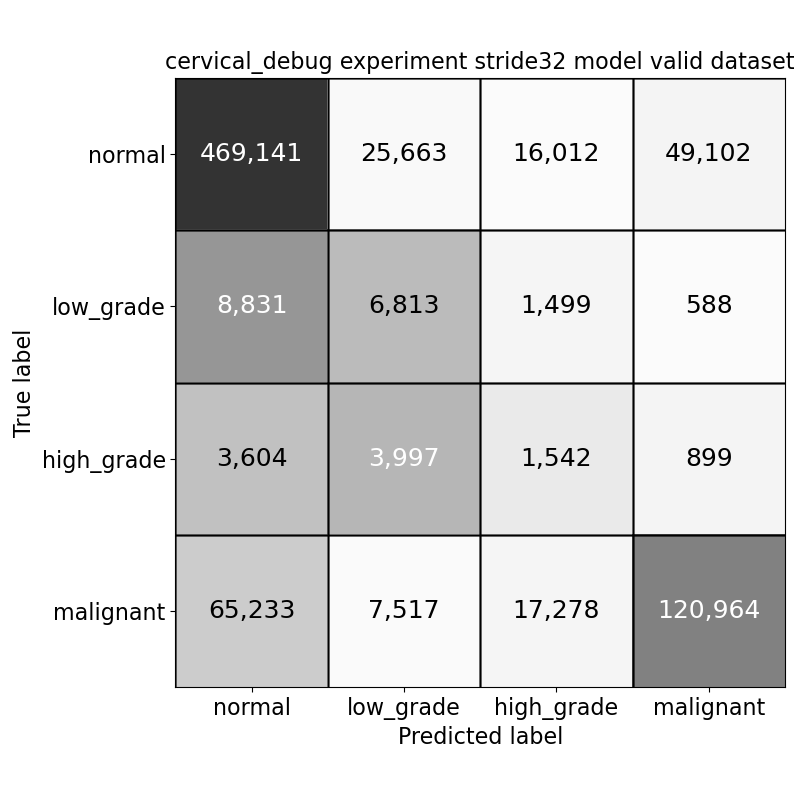

In [16]:
Image.open(experiment_root / 'stride32_results' / 'patch_summaries' / 'valid' / 'confidence_matrix.png')

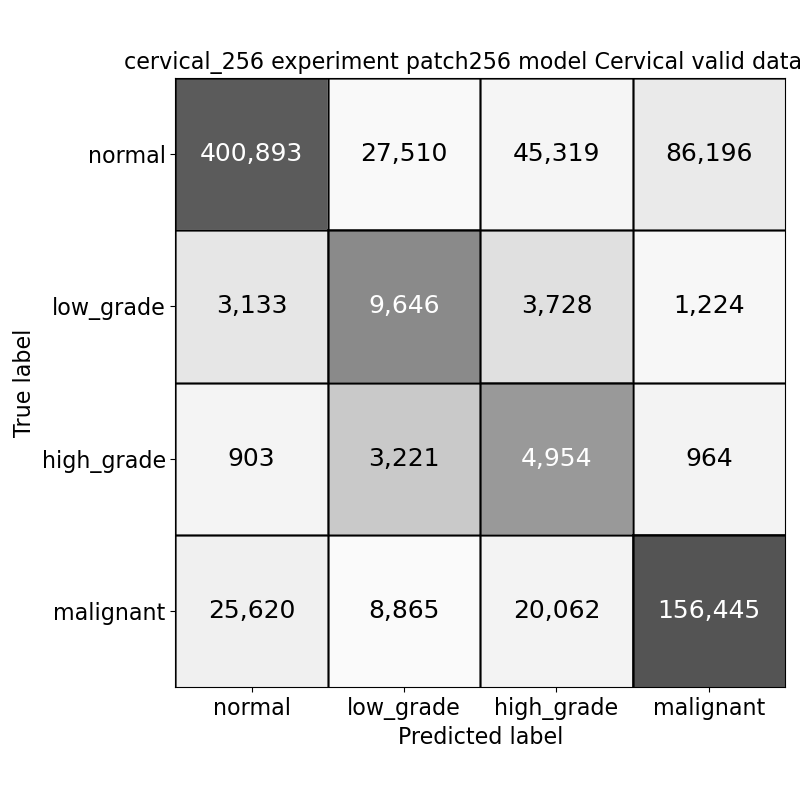

In [17]:
Image.open(project_root() / 'experiments' / 'cervical_256' / 'patch256_results' / 'patch_summaries' / 'valid' / 'confidence_matrix.png')

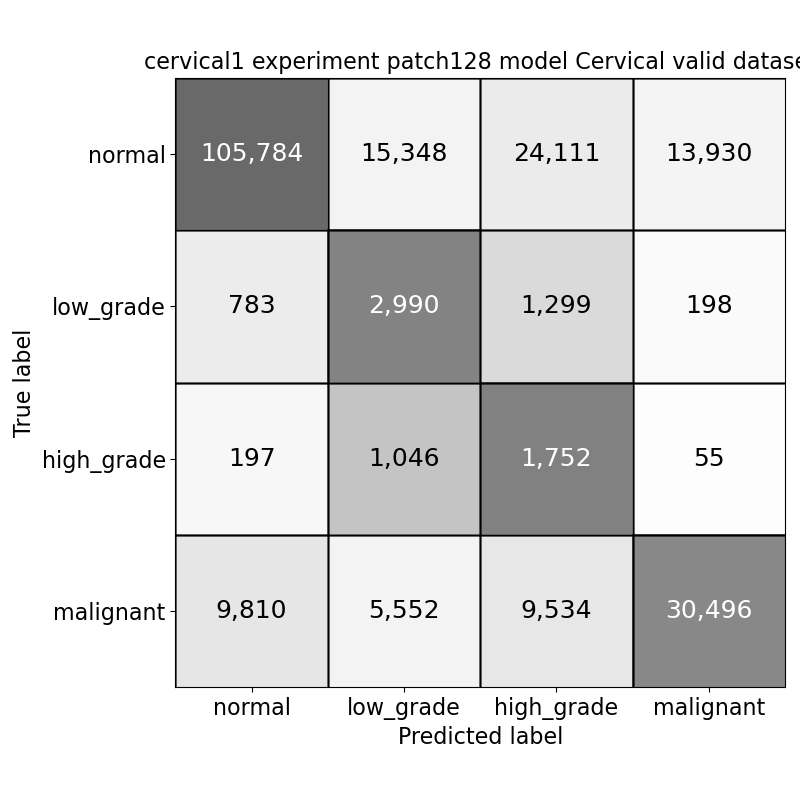

In [18]:
Image.open(project_root() / 'experiments' / 'cervical1' / 'patch_results' / 'patch_summaries' / 'valid' / 'confidence_matrix.png')

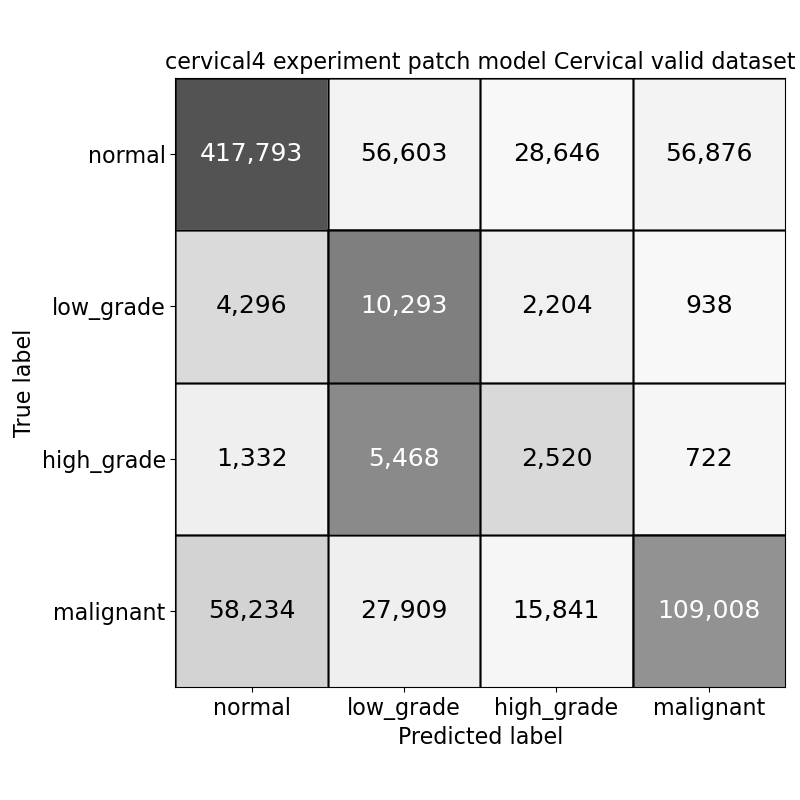

In [23]:
Image.open(project_root() / 'experiments' / 'cervical4' / 'patch_results' / 'patch_summaries' / 'valid' / 'confidence_matrix.png')

In [19]:
from repath.utils.convert import remove_item_from_dict

valid_patches = SlidesIndex.load(cervical.debug(), experiment_root / "valid_index")

for sps in valid_patches:
    just_patch_classes = remove_item_from_dict(sps.dataset.labels, "background")
    column_names = list(just_patch_classes.keys())
    column_names.sort()
    print(column_names)


['high_grade', 'low_grade', 'malignant', 'normal']
['high_grade', 'low_grade', 'malignant', 'normal']
['high_grade', 'low_grade', 'malignant', 'normal']
['high_grade', 'low_grade', 'malignant', 'normal']
['high_grade', 'low_grade', 'malignant', 'normal']
['high_grade', 'low_grade', 'malignant', 'normal']
['high_grade', 'low_grade', 'malignant', 'normal']
['high_grade', 'low_grade', 'malignant', 'normal']
['high_grade', 'low_grade', 'malignant', 'normal']
['high_grade', 'low_grade', 'malignant', 'normal']
['high_grade', 'low_grade', 'malignant', 'normal']
['high_grade', 'low_grade', 'malignant', 'normal']
['high_grade', 'low_grade', 'malignant', 'normal']
['high_grade', 'low_grade', 'malignant', 'normal']
['high_grade', 'low_grade', 'malignant', 'normal']
['high_grade', 'low_grade', 'malignant', 'normal']
['high_grade', 'low_grade', 'malignant', 'normal']
['high_grade', 'low_grade', 'malignant', 'normal']
['high_grade', 'low_grade', 'malignant', 'normal']
['high_grade', 'low_grade', 'ma

In [20]:
from torchvision.datasets import ImageFolder

train_set = ImageFolder(experiment_root / "training_patches")

In [21]:
train_set._find_classes(experiment_root / "training_patches")

(['high_grade', 'low_grade', 'malignant', 'normal'],
 {'high_grade': 0, 'low_grade': 1, 'malignant': 2, 'normal': 3})

In [22]:
import pandas as pd

pd.read_csv(experiment_root / 'pre_hnm_results' / 'valid' / 'results' / 'iCAIRD' / 'IC-CX-01408-01.csv')

,x,y,label,transform,high_grade,low_grade,malignant,normal
0,11520,256,1,1,0.002757,0.008328,0.060301,0.928613
1,11648,256,1,1,0.027308,0.068578,0.028130,0.875985
2,9984,1536,1,1,0.003965,0.007566,0.235472,0.752997
3,10112,1536,1,1,0.024846,0.054305,0.036762,0.884088
4,9984,1664,1,1,0.074696,0.189625,0.009941,0.725738
...,...,...,...,...,...,...,...,...
7638,10624,14336,1,1,0.638503,0.070797,0.015026,0.275673
7639,10752,14336,1,1,0.152731,0.199233,0.027994,0.620042
7640,1792,14976,1,1,0.022096,0.079312,0.004104,0.894488
7641,2048,16512,1,1,0.057612,0.134677,0.017808,0.789904
